In [241]:
import numpy as np
import pandas as pd 
import os
import re
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from sklearn.model_selection import train_test_split

In [242]:
from tqdm.notebook import tqdm

In [243]:
# url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv"
# url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/abusive.csv"
# url = f"https://github.com/rifkisrg/text-mining-project-akhir/raw/70f8fb1c4a9a29cd86a32e15567777506e84ea23/stopwordbahasa.csv"
!wget --no-cache --backups=1 {url}

--2022-04-10 17:13:22--  https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/abusive.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975 [text/plain]
Saving to: ‘abusive.csv’

abusive.csv         100%[===================>]     975  --.-KB/s    in 0s      

2022-04-10 17:13:22 (30.0 MB/s) - ‘abusive.csv’ saved [975/975]



In [244]:
import pandas as pd
import numpy as np

In [245]:
data = pd.read_csv('re_dataset.csv', encoding='latin-1', engine ='python')

In [246]:
alay_dict = pd.read_csv('new_kamusalay.csv', names = ['original', 'replacement'], encoding='latin-1')
abusive_dict = pd.read_csv('abusive.csv', encoding='latin-1')
stopword_dict = pd.read_csv('stopwordbahasa.csv', names = ['stopword'], encoding='latin-1')

In [247]:
abusive_dict.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [248]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('RT',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('USER', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

# def stemming(text):
#     return stemmer.stem(text)

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [249]:
# Test cleaning

In [250]:
print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
# print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe apa kabs hehe
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe


In [251]:
# Source: https://www.kaggle.com/code/corneliustantius/indonesia-hatespeech-recognition-main-notebook
def preprocess1(text):
#     text = lowercase(text) # 1
#     text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
#     text = stemming(text) # 4
    text = remove_stopword(text) # 5
    # text = lowercase(text)
    text = remove_emoticon_byte(text)
    # text = remove_early_space(text)
    text = remove_nonaplhanumeric(text)
    text = text.replace('url', '')
    text = text.replace('amp')
    return text

def preprocess(text):
#     text = lowercase(text) # 1
#     text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
#     text = stemming(text) # 4
#     text = remove_stopword(text) # 5
    text = remove_emoticon_byte(text)
    text = remove_early_space(text)
    text = remove_nonaplhanumeric(text)
    text = lowercase(text)
    text = remove_stopword(text)
    text = text.replace('url', '')
    text = text.replace('amp', '')
    return text

# def classify(hs):
#     retval = ""
#     if int(hs) == 1:
#         retval = 'positive'
#     else:
#         retval = 'negative'
#     return retval

In [252]:
data['text'] = data['Tweet'].apply(preprocess)
data[['text', 'HS']].head(10)

,text,HS
0,cowok berusaha melacak perhatian gue lantas re...,1
1,telat tau elu edan sarap gue bergaul ciga ifla...,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0
3,nku tau matamu sipit diliat,0
4,kaum cebong kafir dongoknya dungu hahahah,1
5,ya bani taplak kawan kawan,1
6,deklarasi pilihan kepala daerah 2018 aman anti...,0
7,gue selesai re watch aldnoah zero kret endingn...,0
8,admin belanja po terbaik nak makan ais kepal m...,0
9,enak ngewe,0


In [253]:
# train = pd.DataFrame()
# train['text'] = X_train
# train['HS'] = y_train 

# test = pd.DataFrame()
# test['text'] = X_test
# test['HS'] = y_test

# train.to_csv('train.csv')
# test.to_csv('train.csv')

data[['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak',
       'HS_Moderate', 'HS_Strong']].sum(axis=0)

HS               5561
Abusive          5043
HS_Individual    3575
HS_Group         1986
HS_Religion       793
HS_Race           566
HS_Physical       323
HS_Gender         306
HS_Other         3740
HS_Weak          3383
HS_Moderate      1705
HS_Strong         473
dtype: int64

In [254]:
hs_df = pd.DataFrame()
hs_df[['text', 'HS', 'Abusive']] = data[['text', 'HS', 'Abusive']]
hs_df.to_csv('hs.csv')

In [255]:
cat_df = pd.DataFrame()
cat_df[['text', 'HS_Individual', 'HS_Group']] = data[['text', 'HS_Individual', 'HS_Group']]
# target_df['label'] = [1 if x.HS_Individual==1 e /lse 0 for (i,x) in target_df.iterrows()]
cat_df.to_csv('cat.csv')

In [256]:
cat_df

,text,HS_Individual,HS_Group
0,cowok berusaha melacak perhatian gue lantas re...,1,0
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0
3,nku tau matamu sipit diliat,0,0
4,kaum cebong kafir dongoknya dungu hahahah,0,1
...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,0
13165,kasur enak kunyuk,0,0
13166,hati hati bisu g nlagi bosan duh,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0


In [257]:
target_df = pd.DataFrame()
target_df[['text', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']] = data[['text', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']]
target_df.to_csv('target_df.csv')

In [258]:
level_df = pd.DataFrame()
level_df[['text', 'HS_Weak', 'HS_Moderate', 'HS_Strong']] = data[['text', 'HS_Weak', 'HS_Moderate', 'HS_Strong']]
level_df.to_csv('level.csv')

In [260]:
X = data['text'].values
y = data['HS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train = pd.DataFrame()
train['text'] = X_train
train['HS'] = y_train 

test = pd.DataFrame()
test['text'] = X_test
test['HS'] = y_test

In [261]:
train.to_csv('train_preprocessed.csv')
test.to_csv('test_preprocessed.csv')

<AxesSubplot:xlabel='HS', ylabel='count'>

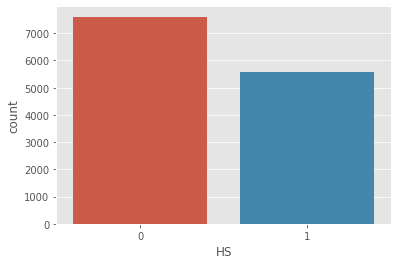

In [262]:
sns.countplot(data.HS)

<AxesSubplot:xlabel='HS', ylabel='count'>

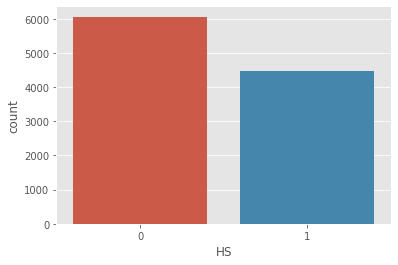

In [263]:
sns.countplot(train.HS)

<AxesSubplot:xlabel='HS', ylabel='count'>

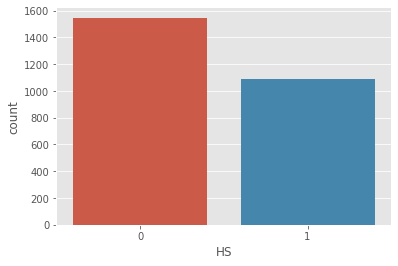

In [264]:
sns.countplot(test.HS)

In [265]:
def s(text):
    return text.split()

positive_text = train[train['HS']==0].text.apply(s)
negative_text = train[train['HS']==1].text.apply(s)

In [266]:
positive_text

1        [berbeda, dibanding, era, jokowi, era, 1971, 8...
3        [agama, energi, disatu, sisi, konstruktif, sis...
6        [dibudakcintakan, anjing, dibudakcintakan, mem...
7        [istilah, kopar, lapor, pki, asing, asing, pri...
8        [klhk, upayakan, pemerataan, ekonomi, tora, ka...
                               ...                        
10528    [bersih, bgst, tisu, bekas, ngelap, silit, had...
10530    [pilkada, serentak, 2018, sumut, contoh, demok...
10531                                       [gembrot, bgt]
10532    [5, posisi, seks, video, tante, ngentot, berci...
10534    [kpk, 10, anggota, dprd, sumut, kembalikan, ua...
Name: text, Length: 6061, dtype: object

In [267]:
top = Counter([item for sublist in positive_text for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,orang,674
1,presiden,507
2,gue,503
3,ya,470
4,agama,390
5,indonesia,344
6,islam,336
7,asing,328
8,n,313
9,i,279


In [268]:
top = Counter([item for sublist in negative_text for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,cebong,412
2,orang,391
3,ya,369
4,indonesia,320
5,islam,310
6,sih,303
7,cina,295
8,presiden,283
9,2019gantipresiden,268
10,nya,267


In [269]:
' '.join([' '.join(x) for x in positive_text])

'berbeda dibanding era jokowi era 1971 88 china as terlibat langsung penyingkiran islam era dominan rezim orba csis elit tionghoa katolik radikal isipasi komunitas tionghoa agama energi disatu sisi konstruktif sisi agama merusak agama bermasalah orang orang berbicara nama agama syaikh abdullah bin bayyah dibudakcintakan anjing dibudakcintakan mempan gila sih gue lage istilah kopar lapor pki asing asing pria no pri sejatinya nkri klhk upayakan pemerataan ekonomi tora kawasan hutan perhutanan sosial tribun medan kakak ya suka berendamnya pakai bunga bangkai special post for pigijo halo teman2 facebook yuk mir tulisan terbaru jelajah pelosok indonesia membahas pesona budaya masya allah bupati orasi demo sukmawati rela dipecat jabatannya dipecat membela agama islam agama islam dilecehkan bupati labuhanbatu dihadapan ribuan umat islam menggelar aksi bela islam 6 4 rr sepe inya belajar hati mengeluarkan statemen gubernur menghasilkan karya jalan lingkar semanggi mengeluarkan dana apbd lihat 

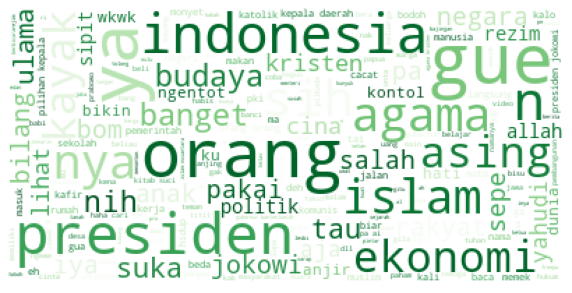

In [270]:
# pos_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask.png'))
wordcloud = WordCloud(background_color='white', max_font_size=50, max_words=200, colormap='Greens').generate(' '.join([' '.join(x) for x in positive_text]))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

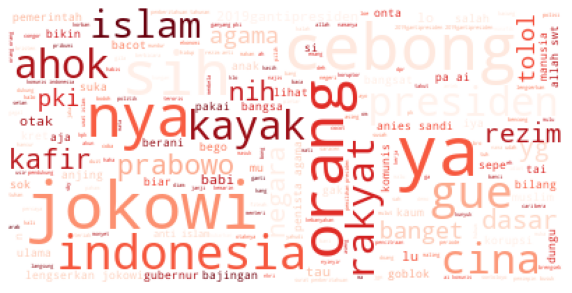

In [271]:
# pos_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask.png'))
wordcloud = WordCloud(background_color='white', max_font_size=50, max_words=200, colormap='Reds').generate(' '.join([' '.join(x) for x in negative_text]))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [272]:
#NLP tools
import re
import nltk
# nltk.download('stopwords')
# nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier


In [273]:
# Logistic Regression
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 84.85%
F1 Score: 0.805081
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1547
           1       0.86      0.76      0.81      1087

    accuracy                           0.85      2634
   macro avg       0.85      0.84      0.84      2634
weighted avg       0.85      0.85      0.85      2634



In [274]:
# MultinomialNB
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 83.75%
F1 Score: 0.793834
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1547
           1       0.83      0.76      0.79      1087

    accuracy                           0.84      2634
   macro avg       0.84      0.83      0.83      2634
weighted avg       0.84      0.84      0.84      2634



In [275]:
# Random Forest Classifier
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 84.21%
F1 Score: 0.803403
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1547
           1       0.83      0.78      0.80      1087

    accuracy                           0.84      2634
   macro avg       0.84      0.83      0.84      2634
weighted avg       0.84      0.84      0.84      2634



In [276]:
# SGD
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 82.08%
F1 Score: 0.747053
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1547
           1       0.89      0.64      0.75      1087

    accuracy                           0.82      2634
   macro avg       0.84      0.79      0.80      2634
weighted avg       0.83      0.82      0.81      2634



In [277]:
test['preds'] = model.predict(X_test)

In [278]:
misclassified = test[test.HS != test.preds]
misclassified[misclassified.HS==0][misclassified.preds==1].head(50)

,text,HS,preds
29,jokowi dpr,0,1
62,doa aminkan malaikat 2019gantipresiden,0,1
90,budek buta otak mati sulit berharap,0,1
139,boss kayak mayoritas non muslim etnis tionghoa...,0,1
155,bidik penista ulama,0,1
171,doeloe rezim orba dolar melambung rp 15 000 ha...,0,1
198,keturunan pki marah,0,1
224,lu jerawatan cakap lu gendut cantik lu putihan...,0,1
242,rohingya muslim rescued at sea off sumatra ind...,0,1
260,jalan jalan ptc nayah pameran ayo naq ayo pame...,0,1


In [279]:
' '.join(misclassified.text.values)

'resah presiden hidup penuh drama pencitraan main ftv joko judulnya  daruratduniaperadilanindonesia pengadilan negeri ajang kebencian sara sih terdakwa seiman hakim seiman ringan hukumannya beda agama hukum seberat beratnya kecuali sogok pakai duit pengadilan indonesia pdiperjuanganmenang kaum sipit menguasai tambang indonesia te awa dasar nasionalisme indonesia pemilu dukung 2 periode hasilnya tambang indonesia dikuasai sipit rezim sekretariat jenderal parai komunis vietnam digelar karpet merah istana jokowi dpr indeks demokrasi menurun indeks komunis pki otoritarianisme moga tindak pelaporan penista agama ade armando langsung ketua fpi kh shobri lubis bareskrim mabes polri gambir jaka a pusat selasa 10 4 13 00 wib perhaps malas deh gue baca nya sok ganteng banget sih onta plakat isinya kerja polisi indonesia polisi tionghoa penjelasan polisinya tolak mabes lihat fotonya kayak selamatan gitu doa aminkan malaikat 2019gantipresiden diradio ya bolot budek buta otak mati sulit berharap as

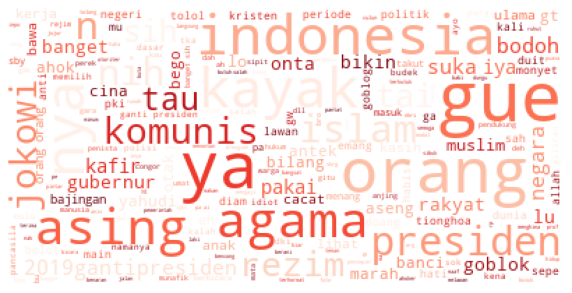

In [280]:
# pos_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask.png'))
wordcloud = WordCloud(background_color='white', max_font_size=50, max_words=200, colormap='Reds').generate(' '.join(misclassified.text.values))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [281]:
model.predict(['gue punya anjing'])

array([0])

# Multiclass Classification (basic models)

## Category classification

In [282]:
# from sklearn.datasets import make_multilabel_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.multioutput import ClassifierChain
# X, Y = make_multilabel_classification(
#    n_samples=12, n_classes=3, random_state=0
# )
# X_train, X_test, Y_train, Y_test = train_test_split(
#    X, Y, random_state=0
# )
# base_lr = LogisticRegression(solver='lbfgs', random_state=0)
# chain = ClassifierChain(base_lr, order='random', random_state=0)
# chain.fit(X_train, Y_train).predict(X_test)

# chain.predict(X_test)

In [283]:
# target
cat_df

,text,HS_Individual,HS_Group
0,cowok berusaha melacak perhatian gue lantas re...,1,0
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0
3,nku tau matamu sipit diliat,0,0
4,kaum cebong kafir dongoknya dungu hahahah,0,1
...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,0
13165,kasur enak kunyuk,0,0
13166,hati hati bisu g nlagi bosan duh,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0


In [284]:
X = cat_df['text'].values
y = cat_df[['HS_Individual', 'HS_Group']].values

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [286]:
# Logistic Regression
base_lr = LogisticRegression(solver='lbfgs', random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(base_lr, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 76.20%
F1 Score: 0.573357
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       702
           1       0.82      0.29      0.43       385

   micro avg       0.74      0.49      0.59      1087
   macro avg       0.77      0.44      0.54      1087
weighted avg       0.76      0.49      0.57      1087
 samples avg       0.20      0.20      0.20      1087



In [287]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(mnb, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 64.09%
F1 Score: 0.227907
              precision    recall  f1-score   support

           0       0.87      0.19      0.31       702
           1       1.00      0.04      0.08       385

   micro avg       0.88      0.14      0.24      1087
   macro avg       0.93      0.11      0.19      1087
weighted avg       0.92      0.14      0.23      1087
 samples avg       0.06      0.06      0.06      1087



In [288]:
# Random Forest
rf = RandomForestClassifier(random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(rf, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 77.41%
F1 Score: 0.610692
              precision    recall  f1-score   support

           0       0.70      0.67      0.68       702
           1       0.82      0.34      0.48       385

   micro avg       0.72      0.55      0.63      1087
   macro avg       0.76      0.50      0.58      1087
weighted avg       0.74      0.55      0.61      1087
 samples avg       0.23      0.23      0.23      1087



In [289]:
# SGD
sgd = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(sgd, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 72.44%
F1 Score: 0.474309
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       702
           1       0.89      0.17      0.28       385

   micro avg       0.75      0.37      0.50      1087
   macro avg       0.81      0.33      0.43      1087
weighted avg       0.78      0.37      0.47      1087
 samples avg       0.15      0.15      0.15      1087



## Target classification

In [290]:
target_df

,text,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,cowok berusaha melacak perhatian gue lantas re...,0,0,0,0,1
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0,0,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0,0,0,0
3,nku tau matamu sipit diliat,0,0,0,0,0
4,kaum cebong kafir dongoknya dungu hahahah,1,0,0,0,0
...,...,...,...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,0,0,1,0,0
13165,kasur enak kunyuk,0,0,0,0,0
13166,hati hati bisu g nlagi bosan duh,0,0,0,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0,0,0,0


In [291]:
X = target_df['text'].values
y = target_df['HS_Religion HS_Race HS_Physical HS_Gender HS_Other'.split()].values


In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [293]:
# Logistic Regression
base_lr = LogisticRegression(solver='lbfgs', random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(base_lr, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 76.96%
F1 Score: 0.597364
              precision    recall  f1-score   support

           0       0.77      0.29      0.42       153
           1       0.87      0.43      0.58       111
           2       0.86      0.10      0.18        59
           3       0.67      0.06      0.12        63
           4       0.80      0.64      0.71       728

   micro avg       0.81      0.51      0.62      1114
   macro avg       0.79      0.31      0.40      1114
weighted avg       0.80      0.51      0.60      1114
 samples avg       0.21      0.21      0.21      1114



In [294]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(mnb, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 66.02%
F1 Score: 0.284085
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       153
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00        59
           3       0.00      0.00      0.00        63
           4       0.89      0.29      0.43       728

   micro avg       0.89      0.19      0.31      1114
   macro avg       0.38      0.06      0.09      1114
weighted avg       0.72      0.19      0.28      1114
 samples avg       0.08      0.08      0.08      1114



In [295]:
# Random Forest
rf = RandomForestClassifier(random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(rf, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 78.40%
F1 Score: 0.618238
              precision    recall  f1-score   support

           0       0.87      0.34      0.49       153
           1       0.85      0.35      0.50       111
           2       0.89      0.14      0.24        59
           3       0.50      0.06      0.11        63
           4       0.76      0.72      0.74       728

   micro avg       0.77      0.56      0.65      1114
   macro avg       0.77      0.32      0.41      1114
weighted avg       0.78      0.56      0.62      1114
 samples avg       0.24      0.24      0.24      1114



In [296]:
# SGD
sgd = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(sgd, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 74.45%
F1 Score: 0.527956
              precision    recall  f1-score   support

           0       0.90      0.17      0.29       153
           1       0.85      0.35      0.50       111
           2       1.00      0.08      0.16        59
           3       0.50      0.02      0.03        63
           4       0.82      0.55      0.66       728

   micro avg       0.83      0.42      0.56      1114
   macro avg       0.81      0.23      0.33      1114
weighted avg       0.83      0.42      0.53      1114
 samples avg       0.18      0.18      0.18      1114



# Level classification

In [297]:
level_df

,text,HS_Weak,HS_Moderate,HS_Strong
0,cowok berusaha melacak perhatian gue lantas re...,1,0,0
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0,0
3,nku tau matamu sipit diliat,0,0,0
4,kaum cebong kafir dongoknya dungu hahahah,0,1,0
...,...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,0,0
13165,kasur enak kunyuk,0,0,0
13166,hati hati bisu g nlagi bosan duh,0,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0,0


In [298]:
X = level_df['text'].values
y = level_df['HS_Weak HS_Moderate HS_Strong'.split()].values

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [300]:
# Logistic Regression
base_lr = LogisticRegression(solver='lbfgs', random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(base_lr, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 74.37%
F1 Score: 0.518419
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       663
           1       0.73      0.20      0.31       335
           2       0.84      0.43      0.57        89

   micro avg       0.70      0.44      0.54      1087
   macro avg       0.75      0.40      0.50      1087
weighted avg       0.71      0.44      0.52      1087
 samples avg       0.18      0.18      0.18      1087



In [301]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(mnb, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 62.03%
F1 Score: 0.147576
              precision    recall  f1-score   support

           0       0.88      0.13      0.23       663
           1       1.00      0.01      0.02       335
           2       0.00      0.00      0.00        89

   micro avg       0.88      0.08      0.15      1087
   macro avg       0.63      0.05      0.08      1087
weighted avg       0.85      0.08      0.15      1087
 samples avg       0.03      0.03      0.03      1087



In [302]:
# Random Forest
rf = RandomForestClassifier(random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(rf, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 75.09%
F1 Score: 0.543943
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       663
           1       0.80      0.21      0.33       335
           2       0.85      0.45      0.59        89

   micro avg       0.70      0.48      0.57      1087
   macro avg       0.78      0.43      0.52      1087
weighted avg       0.73      0.48      0.54      1087
 samples avg       0.20      0.20      0.20      1087



In [303]:
# SGD
sgd = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(sgd, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 70.58%
F1 Score: 0.407664
              precision    recall  f1-score   support

           0       0.68      0.43      0.53       663
           1       0.95      0.06      0.11       335
           2       0.86      0.48      0.62        89

   micro avg       0.71      0.32      0.44      1087
   macro avg       0.83      0.33      0.42      1087
weighted avg       0.78      0.32      0.41      1087
 samples avg       0.13      0.13      0.13      1087



## HS/Abusive classification

In [304]:
hs_df

,text,HS,Abusive
0,cowok berusaha melacak perhatian gue lantas re...,1,1
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,1
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0
3,nku tau matamu sipit diliat,0,0
4,kaum cebong kafir dongoknya dungu hahahah,1,1
...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,1
13165,kasur enak kunyuk,0,1
13166,hati hati bisu g nlagi bosan duh,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0


In [305]:
X = hs_df['text'].values
y = hs_df['HS Abusive'.split()].values

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [307]:
# Logistic Regression
base_lr = LogisticRegression(solver='lbfgs', random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(base_lr, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 77.45%
F1 Score: 0.813123
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1087
           1       0.92      0.81      0.86       992

   micro avg       0.87      0.77      0.81      2079
   macro avg       0.87      0.77      0.82      2079
weighted avg       0.87      0.77      0.81      2079
 samples avg       0.41      0.42      0.41      2079



In [308]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(mnb, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 76.12%
F1 Score: 0.817159
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1087
           1       0.91      0.77      0.83       992

   micro avg       0.84      0.79      0.82      2079
   macro avg       0.85      0.79      0.82      2079
weighted avg       0.85      0.79      0.82      2079
 samples avg       0.44      0.43      0.43      2079



In [309]:
# Random Forest
rf = RandomForestClassifier(random_state=0)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(rf, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 77.94%
F1 Score: 0.830477
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1087
           1       0.89      0.85      0.87       992

   micro avg       0.84      0.82      0.83      2079
   macro avg       0.84      0.82      0.83      2079
weighted avg       0.84      0.82      0.83      2079
 samples avg       0.45      0.45      0.44      2079



In [310]:
# SGD
sgd = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None)

model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
#     ('clf', LogisticRegression(solver='lbfgs', random_state=0)),
    ('cc', ClassifierChain(sgd, order='random', random_state=0)),
])

# model = ClassifierChain(lr, order='random', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Accuracy: 74.60%
F1 Score: 0.781949
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1087
           1       0.93      0.77      0.84       992

   micro avg       0.85      0.72      0.78      2079
   macro avg       0.86      0.72      0.78      2079
weighted avg       0.85      0.72      0.78      2079
 samples avg       0.37      0.39      0.37      2079



# Using NN models

In [313]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
 
# get the dataset
def get_dataset():
	X, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=3, n_labels=2, random_state=1)
	return X, y
 
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		acc = accuracy_score(y_test, yhat)
		# store result
		print('>%.3f' % acc)
		results.append(acc)
	return results
 
# # load dataset
# X, y = get_dataset()
# # # evaluate model
# results = evaluate_model(X, y)
# # summarize performance
# print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

In [314]:
x_t, y_t = get_dataset()

In [315]:
x_t.shape

(1000, 10)

In [316]:
y_t

array([[1, 1, 0],
       [0, 0, 0],
       [1, 1, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 1]])

In [317]:
import numpy as np
np.random.seed(42)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
plt.style.use('ggplot')

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [318]:
from transformers import AutoTokenizer, AutoModel

indobertweet_model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased")

In [319]:
weights = indobertweet_model.embeddings.word_embeddings.weight.detach().numpy()
embedding_matrix = weights

In [320]:
from transformers import AutoTokenizer, AutoModel

indobertweet_model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

In [321]:
max_features = 31923
embedding_dim = 768

In [322]:
def run(model, model_name='', batch_size=32, epochs=20):

#     batch_size = 32
#     epochs = 20
    tf.keras.utils.plot_model(
        model, to_file=model_name+'model.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None, show_layer_activations=False
    )

    checkpoint_filepath = 'checkpoints_multilabel/' + model_name
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, 
                        callbacks=[model_checkpoint_callback])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_loss.png')
    plt.show()
    plt.close()

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training accuracy vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_accuracy.png')
    plt.show()
    plt.close()


    y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
    y_pred = y_pred.round()
    
    print("================================================")

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='weighted')))

## List of Models

In [323]:
import tensorflow as tf 

def recurrent_cnn1(n_outputs):
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(n_outputs, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.Adam(
                        learning_rate=1e-3,
                        beta_1=0.9,
                        beta_2=0.999,
                        epsilon=1e-07,
                        amsgrad=False,
                        name='Adam',
                    ),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

In [324]:
def shallow_model(n_outputs):
    
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False)
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(20, kernel_initializer='he_uniform', activation='relu'),
      keras.layers.Dense(n_outputs, activation='sigmoid')])

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(
                        learning_rate=1e-4,
                        beta_1=0.9,
                        beta_2=0.999,
                        epsilon=1e-07,
                        amsgrad=False,
                        name='Adam',
                    ))
    print(model.summary())

    return model

# Target classification 

In [325]:
tokenized = []

for text in tqdm(target_df['text'].values, total=target_df.shape[0]):
    t = tokenizer(str(text))['input_ids']
    tokenized.append(t)
    
X = tokenized
X = sequence.pad_sequences(X, maxlen=80)

y = target_df['HS_Religion HS_Race HS_Physical HS_Gender HS_Other'.split()].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

100%|██████████| 13169/13169 [00:01<00:00, 9645.20it/s]


In [378]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, epochs=20):
    results = {}
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    print('inputs:', n_inputs)
    print('outputs:', n_outputs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # define model
    model = get_model(n_inputs, n_outputs)
    # fit model
    model.fit(X_train, y_train, epochs=epochs)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate accuracy
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    # store result
    print('Accuracy >%.3f' % acc)
    print('F1-score >%.3f' % f1)
    results['acc'] = acc
    results['f1'] = f1
    return results

In [345]:
results = evaluate_model(X, y, epochs=100)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2857
Epoch 2/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2496
Epoch 3/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2493
Epoch 4/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2487
Epoch 5/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2485
Epoch 6/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2481
Epoch 7/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2475
Epoch 8/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2473
Epoch 9/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2466
Epoch 10/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2461
Epoch 11/100
330/330 [==============================] - 1s 2ms/step - loss: 0.2455
Epoch 12/100
330/330 [==============================] - 1s 2ms/step - loss

330/330 [==============================] - 1s 2ms/step - loss: 0.1777
Epoch 100/100
83/83 [==============================] - 0s 1ms/step
Accuracy >0.703
F1-score >0.428


{'acc': 0.7027334851936219, 'f1': 0.4284518756269272}

In [350]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [351]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/20
330/330 [==============================] - 134s 376ms/step - loss: 0.2605
Epoch 2/20
330/330 [==============================] - 129s 391ms/step - loss: 0.1986
Epoch 3/20
330/330 [==============================] - 126s 381ms/step - loss: 0.1668
Epoch 4/20
330/330 [==============================] - 125s 380ms/step - loss: 0.1540
Epoch 5/20
330/330 [==============================] - 126s 383ms/step - loss: 0.1453
Epoch 6/20
330/330 [==============================] - 131s 397ms/step - loss: 0.1345
Epoch 7/20
330/330 [==============================] - 132s 400ms/step - loss: 0.1266
Epoch 8/20
330/330 [==============================] - 126s 382ms/step - loss: 0.1219
Epoch 9/20
330/330 [==============================] - 125s 378ms/step - loss: 0.1138
Epoch 10/20
330/330 [==============================] - 125s 378ms/step - loss: 0.1088
Epoch 11/20
330/330 [==============================] - 126s 382ms/step - loss: 0.1020
Epoch 12/20
330/330 [====================

{'acc': 0.7942293090356871, 'f1': 0.713059669794783}

In [361]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.GRU(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [362]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/20
330/330 [==============================] - 16s 43ms/step - loss: 0.2356
Epoch 2/20
330/330 [==============================] - 14s 43ms/step - loss: 0.1601
Epoch 3/20
330/330 [==============================] - 14s 43ms/step - loss: 0.1397
Epoch 4/20
330/330 [==============================] - 14s 42ms/step - loss: 0.1253
Epoch 5/20
330/330 [==============================] - 14s 42ms/step - loss: 0.1139
Epoch 6/20
330/330 [==============================] - 14s 42ms/step - loss: 0.1046
Epoch 7/20
330/330 [==============================] - 14s 41ms/step - loss: 0.0949
Epoch 8/20
330/330 [==============================] - 14s 42ms/step - loss: 0.0852
Epoch 9/20
330/330 [==============================] - 14s 41ms/step - loss: 0.0768
Epoch 10/20
330/330 [==============================] - 14s 41ms/step - loss: 0.0683
Epoch 11/20
330/330 [==============================] - 14s 42ms/step - loss: 0.0593
Epoch 12/20
330/330 [==============================] - 13s 41ms

{'acc': 0.7729688686408505, 'f1': 0.6722843025911697}

In [363]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.LSTM(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/20
330/330 [==============================] - 18s 47ms/step - loss: 0.2451
Epoch 2/20
330/330 [==============================] - 16s 49ms/step - loss: 0.1776
Epoch 3/20
330/330 [==============================] - 16s 48ms/step - loss: 0.1588
Epoch 4/20
330/330 [==============================] - 16s 49ms/step - loss: 0.1441
Epoch 5/20
330/330 [==============================] - 16s 48ms/step - loss: 0.1315
Epoch 6/20
330/330 [==============================] - 16s 48ms/step - loss: 0.1203
Epoch 7/20
330/330 [==============================] - 16s 48ms/step - loss: 0.1114
Epoch 8/20
330/330 [==============================] - 16s 49ms/step - loss: 0.1015
Epoch 9/20
330/330 [==============================] - 16s 49ms/step - loss: 0.0928
Epoch 10/20
330/330 [==============================] - 16s 49ms/step - loss: 0.0871
Epoch 11/20
330/330 [==============================] - 16s 49ms/step - loss: 0.0772
Epoch 12/20
330/330 [==============================] - 18s 54ms

{'acc': 0.7665148063781321, 'f1': 0.6518752288699519}

In [364]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.GRU(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/20
330/330 [==============================] - 25s 68ms/step - loss: 0.2202
Epoch 2/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1582
Epoch 3/20
330/330 [==============================] - 23s 70ms/step - loss: 0.1367
Epoch 4/20
330/330 [==============================] - 23s 70ms/step - loss: 0.1237
Epoch 5/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1118
Epoch 6/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1008
Epoch 7/20
330/330 [==============================] - 23s 70ms/step - loss: 0.0923
Epoch 8/20
330/330 [==============================] - 23s 70ms/step - loss: 0.0815
Epoch 9/20
330/330 [==============================] - 23s 69ms/step - loss: 0.0742
Epoch 10/20
330/330 [==============================] - 23s 70ms/step - loss: 0.0652
Epoch 11/20
330/330 [==============================] - 23s 70ms/step - loss: 0.0570
Epoch 12/20
330/330 [==============================] - 23s 70ms

{'acc': 0.7798025816249051, 'f1': 0.6770003044938967}

In [365]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 5
Epoch 1/20
330/330 [==============================] - 30s 82ms/step - loss: 0.2254
Epoch 2/20
330/330 [==============================] - 28s 83ms/step - loss: 0.1655
Epoch 3/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1436
Epoch 4/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1308
Epoch 5/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1192
Epoch 6/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1078
Epoch 7/20
330/330 [==============================] - 27s 83ms/step - loss: 0.0978
Epoch 8/20
330/330 [==============================] - 28s 84ms/step - loss: 0.0902
Epoch 9/20
330/330 [==============================] - 27s 83ms/step - loss: 0.0803
Epoch 10/20
330/330 [==============================] - 27s 82ms/step - loss: 0.0736
Epoch 11/20
330/330 [==============================] - 27s 82ms/step - loss: 0.0647
Epoch 12/20
330/330 [==============================] - 27s 82ms

{'acc': 0.7820804859529233, 'f1': 0.6768259699647341}

## Category classification

In [366]:
cat_df

,text,HS_Individual,HS_Group
0,cowok berusaha melacak perhatian gue lantas re...,1,0
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0
3,nku tau matamu sipit diliat,0,0
4,kaum cebong kafir dongoknya dungu hahahah,0,1
...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,0
13165,kasur enak kunyuk,0,0
13166,hati hati bisu g nlagi bosan duh,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0


In [368]:
tokenized = []

for text in tqdm(cat_df['text'].values, total=cat_df.shape[0]):
    t = tokenizer(str(text))['input_ids']
    tokenized.append(t)
    
X = tokenized
X = sequence.pad_sequences(X, maxlen=80)

y = cat_df['HS_Individual HS_Group'.split()].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

100%|██████████| 13169/13169 [00:01<00:00, 9566.30it/s]


In [369]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, epochs=20):
    results = {}
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    print('inputs:', n_inputs)
    print('outputs:', n_outputs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # define model
    model = get_model(n_inputs, n_outputs)
    # fit model
    model.fit(X_train, y_train, epochs=epochs)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate accuracy
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    # store result
    print('Accuracy >%.3f' % acc)
    print('F1-score >%.3f' % f1)
    results['acc'] = acc
    results['f1'] = f1
    return results

In [370]:
results = evaluate_model(X, y, epochs=100)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5184
Epoch 2/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5090
Epoch 3/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5070
Epoch 4/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5045
Epoch 5/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5026
Epoch 6/100
330/330 [==============================] - 1s 2ms/step - loss: 0.5000
Epoch 7/100
330/330 [==============================] - 1s 2ms/step - loss: 0.4980
Epoch 8/100
330/330 [==============================] - 1s 3ms/step - loss: 0.4940
Epoch 9/100
330/330 [==============================] - 1s 2ms/step - loss: 0.4919
Epoch 10/100
330/330 [==============================] - 1s 2ms/step - loss: 0.4885
Epoch 11/100
330/330 [==============================] - 1s 2ms/step - loss: 0.4856
Epoch 12/100
330/330 [==============================] - 1s 2ms/step - loss

330/330 [==============================] - 1s 2ms/step - loss: 0.3784
Epoch 100/100
83/83 [==============================] - 0s 1ms/step
Accuracy >0.710
F1-score >0.494


{'acc': 0.7103264996203493, 'f1': 0.49350358684987966}

In [371]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [372]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 134s 376ms/step - loss: 0.4798
Epoch 2/20
330/330 [==============================] - 123s 372ms/step - loss: 0.3887
Epoch 3/20
330/330 [==============================] - 126s 381ms/step - loss: 0.3584
Epoch 4/20
330/330 [==============================] - 132s 401ms/step - loss: 0.3416
Epoch 5/20
330/330 [==============================] - 136s 411ms/step - loss: 0.3228
Epoch 6/20
330/330 [==============================] - 150s 455ms/step - loss: 0.3162
Epoch 7/20
330/330 [==============================] - 139s 420ms/step - loss: 0.3056
Epoch 8/20
330/330 [==============================] - 138s 418ms/step - loss: 0.2880
Epoch 9/20
330/330 [==============================] - 136s 412ms/step - loss: 0.2769
Epoch 10/20
330/330 [==============================] - 139s 420ms/step - loss: 0.2664
Epoch 11/20
330/330 [==============================] - 143s 433ms/step - loss: 0.2509
Epoch 12/20
330/330 [====================

{'acc': 0.7714502657555049, 'f1': 0.6149772280962937}

In [373]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.GRU(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [374]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 15s 40ms/step - loss: 0.4390
Epoch 2/20
330/330 [==============================] - 13s 41ms/step - loss: 0.3410
Epoch 3/20
330/330 [==============================] - 13s 40ms/step - loss: 0.3130
Epoch 4/20
330/330 [==============================] - 13s 40ms/step - loss: 0.2929
Epoch 5/20
330/330 [==============================] - 14s 41ms/step - loss: 0.2699
Epoch 6/20
330/330 [==============================] - 13s 40ms/step - loss: 0.2538
Epoch 7/20
330/330 [==============================] - 13s 41ms/step - loss: 0.2282
Epoch 8/20
330/330 [==============================] - 13s 40ms/step - loss: 0.2075
Epoch 9/20
330/330 [==============================] - 13s 40ms/step - loss: 0.1811
Epoch 10/20
330/330 [==============================] - 13s 41ms/step - loss: 0.1531
Epoch 11/20
330/330 [==============================] - 13s 39ms/step - loss: 0.1298
Epoch 12/20
330/330 [==============================] - 13s 41ms

{'acc': 0.768413059984814, 'f1': 0.6287161151015435}

In [375]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.LSTM(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 17s 45ms/step - loss: 0.4498
Epoch 2/20
330/330 [==============================] - 15s 46ms/step - loss: 0.3645
Epoch 3/20
330/330 [==============================] - 15s 46ms/step - loss: 0.3295
Epoch 4/20
330/330 [==============================] - 15s 46ms/step - loss: 0.3074
Epoch 5/20
330/330 [==============================] - 15s 46ms/step - loss: 0.2871
Epoch 6/20
330/330 [==============================] - 15s 46ms/step - loss: 0.2668
Epoch 7/20
330/330 [==============================] - 15s 46ms/step - loss: 0.2427
Epoch 8/20
330/330 [==============================] - 16s 47ms/step - loss: 0.2231
Epoch 9/20
330/330 [==============================] - 15s 46ms/step - loss: 0.1991
Epoch 10/20
330/330 [==============================] - 15s 46ms/step - loss: 0.1766
Epoch 11/20
330/330 [==============================] - 15s 47ms/step - loss: 0.1507
Epoch 12/20
330/330 [==============================] - 15s 45ms

{'acc': 0.7665148063781321, 'f1': 0.6292983903950844}

In [376]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.GRU(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 27s 63ms/step - loss: 0.4486
Epoch 2/20
330/330 [==============================] - 23s 69ms/step - loss: 0.3455
Epoch 3/20
330/330 [==============================] - 24s 74ms/step - loss: 0.3153
Epoch 4/20
330/330 [==============================] - 25s 74ms/step - loss: 0.2931
Epoch 5/20
330/330 [==============================] - 23s 68ms/step - loss: 0.2670
Epoch 6/20
330/330 [==============================] - 22s 68ms/step - loss: 0.2502
Epoch 7/20
330/330 [==============================] - 23s 69ms/step - loss: 0.2235
Epoch 8/20
330/330 [==============================] - 22s 68ms/step - loss: 0.1983
Epoch 9/20
330/330 [==============================] - 22s 68ms/step - loss: 0.1734
Epoch 10/20
330/330 [==============================] - 22s 68ms/step - loss: 0.1513
Epoch 11/20
330/330 [==============================] - 23s 68ms/step - loss: 0.1267
Epoch 12/20
330/330 [==============================] - 22s 68ms

{'acc': 0.7672741078208049, 'f1': 0.6377666602566657}

In [377]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 29s 81ms/step - loss: 0.4441
Epoch 2/20
330/330 [==============================] - 27s 83ms/step - loss: 0.3589
Epoch 3/20
330/330 [==============================] - 27s 81ms/step - loss: 0.3233
Epoch 4/20
330/330 [==============================] - 28s 84ms/step - loss: 0.2975
Epoch 5/20
330/330 [==============================] - 28s 84ms/step - loss: 0.2765
Epoch 6/20
330/330 [==============================] - 28s 86ms/step - loss: 0.2559
Epoch 7/20
330/330 [==============================] - 33s 100ms/step - loss: 0.2332
Epoch 8/20
330/330 [==============================] - 31s 93ms/step - loss: 0.2134
Epoch 9/20
330/330 [==============================] - 33s 99ms/step - loss: 0.1885
Epoch 10/20
330/330 [==============================] - 32s 96ms/step - loss: 0.1658
Epoch 11/20
330/330 [==============================] - 31s 94ms/step - loss: 0.1449
Epoch 12/20
330/330 [==============================] - 31s 93m

{'acc': 0.7661351556567958, 'f1': 0.626806232045808}

## Level classification

In [379]:
level_df

,text,HS_Weak,HS_Moderate,HS_Strong
0,cowok berusaha melacak perhatian gue lantas re...,1,0,0
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,0,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0,0
3,nku tau matamu sipit diliat,0,0,0
4,kaum cebong kafir dongoknya dungu hahahah,0,1,0
...,...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,0,0
13165,kasur enak kunyuk,0,0,0
13166,hati hati bisu g nlagi bosan duh,0,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0,0


In [380]:
tokenized = []

for text in tqdm(level_df['text'].values, total=level_df.shape[0]):
    t = tokenizer(str(text))['input_ids']
    tokenized.append(t)

X = tokenized
X = sequence.pad_sequences(X, maxlen=80)

y = level_df['HS_Weak HS_Moderate HS_Strong'.split()].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

100%|██████████| 13169/13169 [00:01<00:00, 7025.72it/s]


In [381]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, epochs=20):
    results = {}
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    print('inputs:', n_inputs)
    print('outputs:', n_outputs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # define model
    model = get_model(n_inputs, n_outputs)
    # fit model
    model.fit(X_train, y_train, epochs=epochs)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate accuracy
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    # store result
    print('Accuracy >%.3f' % acc)
    print('F1-score >%.3f' % f1)
    results['acc'] = acc
    results['f1'] = f1
    return results

In [382]:
results = evaluate_model(X, y, epochs=100)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3883
Epoch 2/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3750
Epoch 3/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3735
Epoch 4/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3726
Epoch 5/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3709
Epoch 6/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3695
Epoch 7/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3678
Epoch 8/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3659
Epoch 9/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3644
Epoch 10/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3627
Epoch 11/100
330/330 [==============================] - 1s 2ms/step - loss: 0.3611
Epoch 12/100
330/330 [==============================] - 1s 2ms/step - loss

330/330 [==============================] - 1s 2ms/step - loss: 0.2794
Epoch 100/100
83/83 [==============================] - 0s 1ms/step
Accuracy >0.685
F1-score >0.403


{'acc': 0.6845102505694761, 'f1': 0.4025215399410245}

In [383]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [384]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/20
330/330 [==============================] - 148s 416ms/step - loss: 0.3693
Epoch 2/20
330/330 [==============================] - 137s 414ms/step - loss: 0.2995
Epoch 3/20
330/330 [==============================] - 143s 434ms/step - loss: 0.2725
Epoch 4/20
330/330 [==============================] - 155s 471ms/step - loss: 0.2550
Epoch 5/20
330/330 [==============================] - 141s 426ms/step - loss: 0.2440
Epoch 6/20
330/330 [==============================] - 138s 417ms/step - loss: 0.2335
Epoch 7/20
330/330 [==============================] - 138s 417ms/step - loss: 0.2261
Epoch 8/20
330/330 [==============================] - 145s 440ms/step - loss: 0.2148
Epoch 9/20
330/330 [==============================] - 149s 450ms/step - loss: 0.2053
Epoch 10/20
330/330 [==============================] - 159s 482ms/step - loss: 0.1975
Epoch 11/20
330/330 [==============================] - 156s 472ms/step - loss: 0.1862
Epoch 12/20
330/330 [====================

{'acc': 0.7570235383447228, 'f1': 0.6167833875744835}

In [385]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.GRU(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [386]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/20
330/330 [==============================] - 18s 47ms/step - loss: 0.3421
Epoch 2/20
330/330 [==============================] - 15s 47ms/step - loss: 0.2604
Epoch 3/20
330/330 [==============================] - 16s 48ms/step - loss: 0.2309
Epoch 4/20
330/330 [==============================] - 17s 51ms/step - loss: 0.2160
Epoch 5/20
330/330 [==============================] - 17s 52ms/step - loss: 0.1969
Epoch 6/20
330/330 [==============================] - 18s 54ms/step - loss: 0.1829
Epoch 7/20
330/330 [==============================] - 15s 44ms/step - loss: 0.1617
Epoch 8/20
330/330 [==============================] - 14s 42ms/step - loss: 0.1412
Epoch 9/20
330/330 [==============================] - 15s 44ms/step - loss: 0.1216
Epoch 10/20
330/330 [==============================] - 16s 48ms/step - loss: 0.1049
Epoch 11/20
330/330 [==============================] - 15s 45ms/step - loss: 0.0888
Epoch 12/20
330/330 [==============================] - 15s 46ms

{'acc': 0.741837509491268, 'f1': 0.5629276371580176}

In [387]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.LSTM(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/20
330/330 [==============================] - 20s 54ms/step - loss: 0.3594
Epoch 2/20
330/330 [==============================] - 16s 47ms/step - loss: 0.2836
Epoch 3/20
330/330 [==============================] - 19s 57ms/step - loss: 0.2519
Epoch 4/20
330/330 [==============================] - 18s 55ms/step - loss: 0.2317
Epoch 5/20
330/330 [==============================] - 17s 53ms/step - loss: 0.2179
Epoch 6/20
330/330 [==============================] - 17s 51ms/step - loss: 0.2035
Epoch 7/20
330/330 [==============================] - 17s 52ms/step - loss: 0.1878
Epoch 8/20
330/330 [==============================] - 18s 54ms/step - loss: 0.1745
Epoch 9/20
330/330 [==============================] - 17s 51ms/step - loss: 0.1619
Epoch 10/20
330/330 [==============================] - 18s 54ms/step - loss: 0.1442
Epoch 11/20
330/330 [==============================] - 19s 57ms/step - loss: 0.1300
Epoch 12/20
330/330 [==============================] - 18s 53ms

{'acc': 0.7513287775246773, 'f1': 0.6008852285415186}

In [388]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.GRU(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/20
330/330 [==============================] - 28s 75ms/step - loss: 0.3339
Epoch 2/20
330/330 [==============================] - 24s 72ms/step - loss: 0.2574
Epoch 3/20
330/330 [==============================] - 25s 75ms/step - loss: 0.2321
Epoch 4/20
330/330 [==============================] - 24s 73ms/step - loss: 0.2167
Epoch 5/20
330/330 [==============================] - 24s 72ms/step - loss: 0.1979
Epoch 6/20
330/330 [==============================] - 25s 75ms/step - loss: 0.1861
Epoch 7/20
330/330 [==============================] - 25s 75ms/step - loss: 0.1674
Epoch 8/20
330/330 [==============================] - 28s 84ms/step - loss: 0.1494
Epoch 9/20
330/330 [==============================] - 24s 74ms/step - loss: 0.1301
Epoch 10/20
330/330 [==============================] - 25s 76ms/step - loss: 0.1129
Epoch 11/20
330/330 [==============================] - 24s 73ms/step - loss: 0.0948
Epoch 12/20
330/330 [==============================] - 24s 73ms

{'acc': 0.7494305239179955, 'f1': 0.6115792078489402}

In [389]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 3
Epoch 1/20
330/330 [==============================] - 35s 87ms/step - loss: 0.3356
Epoch 2/20
330/330 [==============================] - 31s 93ms/step - loss: 0.2678
Epoch 3/20
330/330 [==============================] - 29s 88ms/step - loss: 0.2396
Epoch 4/20
330/330 [==============================] - 31s 93ms/step - loss: 0.2203
Epoch 5/20
330/330 [==============================] - 29s 88ms/step - loss: 0.2039
Epoch 6/20
330/330 [==============================] - 36s 108ms/step - loss: 0.1880
Epoch 7/20
330/330 [==============================] - 32s 96ms/step - loss: 0.1716
Epoch 8/20
330/330 [==============================] - 28s 86ms/step - loss: 0.1557
Epoch 9/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1389
Epoch 10/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1192
Epoch 11/20
330/330 [==============================] - 27s 83ms/step - loss: 0.1138
Epoch 12/20
330/330 [==============================] - 27s 80m

{'acc': 0.7463933181473045, 'f1': 0.5958982338087125}

## HS classification

In [390]:
hs_df

,text,HS,Abusive
0,cowok berusaha melacak perhatian gue lantas re...,1,1
1,telat tau elu edan sarap gue bergaul ciga ifla...,0,1
2,41 kadang berfikir percaya tuhan jatuh berkali...,0,0
3,nku tau matamu sipit diliat,0,0
4,kaum cebong kafir dongoknya dungu hahahah,1,1
...,...,...,...
13164,berbicara ndasmu congor sekata anjyng,1,1
13165,kasur enak kunyuk,0,1
13166,hati hati bisu g nlagi bosan duh,0,0
13167,bom real mudah terdeteksi bom terkubur dahsyat...,0,0


In [391]:
tokenized = []

for text in tqdm(hs_df['text'].values, total=hs_df.shape[0]):
    t = tokenizer(str(text))['input_ids']
    tokenized.append(t)

X = tokenized
X = sequence.pad_sequences(X, maxlen=80)

y = hs_df['HS Abusive'.split()].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

100%|██████████| 13169/13169 [00:01<00:00, 7831.46it/s]


In [392]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y, epochs=20):
    results = {}
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    print('inputs:', n_inputs)
    print('outputs:', n_outputs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # define model
    model = get_model(n_inputs, n_outputs)
    # fit model
    model.fit(X_train, y_train, epochs=epochs)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate accuracy
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    # store result
    print('Accuracy >%.3f' % acc)
    print('F1-score >%.3f' % f1)
    results['acc'] = acc
    results['f1'] = f1
    return results

In [393]:
results = evaluate_model(X, y, epochs=100)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6767
Epoch 2/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6736
Epoch 3/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6701
Epoch 4/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6662
Epoch 5/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6589
Epoch 6/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6504
Epoch 7/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6417
Epoch 8/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6327
Epoch 9/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6217
Epoch 10/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6116
Epoch 11/100
330/330 [==============================] - 1s 2ms/step - loss: 0.6014
Epoch 12/100
330/330 [==============================] - 1s 2ms/step - loss

330/330 [==============================] - 1s 2ms/step - loss: 0.3967
Epoch 100/100
83/83 [==============================] - 0s 1ms/step
Accuracy >0.687
F1-score >0.772


{'acc': 0.6867881548974943, 'f1': 0.772011374971728}

In [394]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True, dropout=0.1, recurrent_dropout=0.3)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [395]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 132s 369ms/step - loss: 0.5552
Epoch 2/20
330/330 [==============================] - 126s 383ms/step - loss: 0.3903
Epoch 3/20
330/330 [==============================] - 154s 468ms/step - loss: 0.3510
Epoch 4/20
330/330 [==============================] - 208s 629ms/step - loss: 0.3213
Epoch 5/20
330/330 [==============================] - 248s 753ms/step - loss: 0.3008
Epoch 6/20
330/330 [==============================] - 146s 442ms/step - loss: 0.2879
Epoch 7/20
330/330 [==============================] - 143s 433ms/step - loss: 0.2730
Epoch 8/20
330/330 [==============================] - 134s 405ms/step - loss: 0.2584
Epoch 9/20
330/330 [==============================] - 137s 414ms/step - loss: 0.2470
Epoch 10/20
330/330 [==============================] - 137s 415ms/step - loss: 0.2308
Epoch 11/20
330/330 [==============================] - 126s 382ms/step - loss: 0.2240
Epoch 12/20
330/330 [====================

{'acc': 0.8173880030372058, 'f1': 0.86912266595562}

In [396]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.GRU(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [397]:
results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 21s 53ms/step - loss: 0.4457
Epoch 2/20
330/330 [==============================] - 16s 47ms/step - loss: 0.3197
Epoch 3/20
330/330 [==============================] - 14s 43ms/step - loss: 0.2829
Epoch 4/20
330/330 [==============================] - 14s 42ms/step - loss: 0.2561
Epoch 5/20
330/330 [==============================] - 14s 42ms/step - loss: 0.2289
Epoch 6/20
330/330 [==============================] - 14s 43ms/step - loss: 0.2078
Epoch 7/20
330/330 [==============================] - 15s 44ms/step - loss: 0.1828
Epoch 8/20
330/330 [==============================] - 14s 42ms/step - loss: 0.1617
Epoch 9/20
330/330 [==============================] - 15s 46ms/step - loss: 0.1416
Epoch 10/20
330/330 [==============================] - 16s 49ms/step - loss: 0.1232
Epoch 11/20
330/330 [==============================] - 16s 48ms/step - loss: 0.0999
Epoch 12/20
330/330 [==============================] - 14s 42ms

{'acc': 0.784738041002278, 'f1': 0.844014031011144}

In [398]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.LSTM(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 20s 56ms/step - loss: 0.4682
Epoch 2/20
330/330 [==============================] - 17s 50ms/step - loss: 0.3437
Epoch 3/20
330/330 [==============================] - 18s 54ms/step - loss: 0.3008
Epoch 4/20
330/330 [==============================] - 18s 53ms/step - loss: 0.2756
Epoch 5/20
330/330 [==============================] - 17s 53ms/step - loss: 0.2441
Epoch 6/20
330/330 [==============================] - 17s 51ms/step - loss: 0.2207
Epoch 7/20
330/330 [==============================] - 18s 54ms/step - loss: 0.1972
Epoch 8/20
330/330 [==============================] - 20s 60ms/step - loss: 0.1754
Epoch 9/20
330/330 [==============================] - 20s 60ms/step - loss: 0.1523
Epoch 10/20
330/330 [==============================] - 21s 63ms/step - loss: 0.1324
Epoch 11/20
330/330 [==============================] - 19s 57ms/step - loss: 0.1182
Epoch 12/20
330/330 [==============================] - 16s 49ms

{'acc': 0.7744874715261959, 'f1': 0.8315644327118519}

In [399]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.GRU(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 29s 77ms/step - loss: 0.4599
Epoch 2/20
330/330 [==============================] - 23s 69ms/step - loss: 0.3234
Epoch 3/20
330/330 [==============================] - 23s 69ms/step - loss: 0.2859
Epoch 4/20
330/330 [==============================] - 24s 72ms/step - loss: 0.2554
Epoch 5/20
330/330 [==============================] - 30s 92ms/step - loss: 0.2329
Epoch 6/20
330/330 [==============================] - 30s 90ms/step - loss: 0.2053
Epoch 7/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1834
Epoch 8/20
330/330 [==============================] - 25s 74ms/step - loss: 0.1623
Epoch 9/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1384
Epoch 10/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1238
Epoch 11/20
330/330 [==============================] - 23s 69ms/step - loss: 0.1010
Epoch 12/20
330/330 [==============================] - 27s 83ms

{'acc': 0.7794229309035687, 'f1': 0.8388503711635645}

In [400]:
def get_model(n_inputs, n_outputs):
    model = keras.Sequential([
        keras.layers.Embedding(max_features, embedding_dim, weights=[weights], trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_outputs, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

results = evaluate_model(X, y)
# summarize performance
results

inputs: 80
outputs: 2
Epoch 1/20
330/330 [==============================] - 29s 81ms/step - loss: 0.4785
Epoch 2/20
330/330 [==============================] - 28s 85ms/step - loss: 0.3373
Epoch 3/20
330/330 [==============================] - 29s 88ms/step - loss: 0.2918
Epoch 4/20
330/330 [==============================] - 28s 85ms/step - loss: 0.2659
Epoch 5/20
330/330 [==============================] - 27s 82ms/step - loss: 0.2335
Epoch 6/20
330/330 [==============================] - 27s 82ms/step - loss: 0.2124
Epoch 7/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1902
Epoch 8/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1645
Epoch 9/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1484
Epoch 10/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1333
Epoch 11/20
330/330 [==============================] - 27s 82ms/step - loss: 0.1139
Epoch 12/20
330/330 [==============================] - 27s 83ms

{'acc': 0.7873955960516325, 'f1': 0.8432081892121555}